# Analysis of Fake News Detection on Social Media Using Geometric Deep Learning

# 0.0 Imports

In [71]:
import os

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_max_pool
from torch_geometric.transforms import ToUndirected

import networkx as nx
import matplotlib.pyplot as plt

import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1.0 Load Dataset

In [72]:
dataset = 'gossipcop'  # Choose from ['politifact', 'gossipcop']
feature = 'bert'  # Choose from ['profile', 'spacy', 'bert', 'content']
model_type = 'GCN'  # Choose from ['GCN', 'GAT', 'SAGE']
path = os.path.join(os.getcwd(), 'data', 'UPFD')

train_dataset = UPFD(path, dataset, feature, 'train', ToUndirected())
val_dataset = UPFD(path, dataset, feature, 'val', ToUndirected())
test_dataset = UPFD(path, dataset, feature, 'test', ToUndirected())

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


## 1.2 Visualize Dataset

note: this dataset is only the graph, without the tweet content

data.x - these are the text embedding 'features'. So for example dataset[0] has 72 nodes each with 300 features (numeric values in 300 dimension space).

number of data points: torch.Size([76, 768])
tensor([1])
1092
Node features shape: torch.Size([125, 768])
First 5 node features:
tensor([[-0.0895, -0.0141, -0.2686,  ...,  0.1738,  0.3480,  0.1831],
        [ 0.0600,  0.0440,  0.0087,  ...,  0.4195,  0.0239,  0.5018],
        [ 0.1362, -0.0738,  0.0080,  ...,  0.3674, -0.1551,  0.3255],
        [ 0.0732,  0.0991,  0.0817,  ...,  0.4510,  0.0165,  0.5247],
        [-0.0380, -0.0662,  0.0442,  ...,  0.5700, -0.0260,  0.3674]])
Edge index shape: torch.Size([2, 248])
First 5 edges:
tensor([[0, 0, 0, 0, 0],
        [1, 2, 3, 4, 5]])


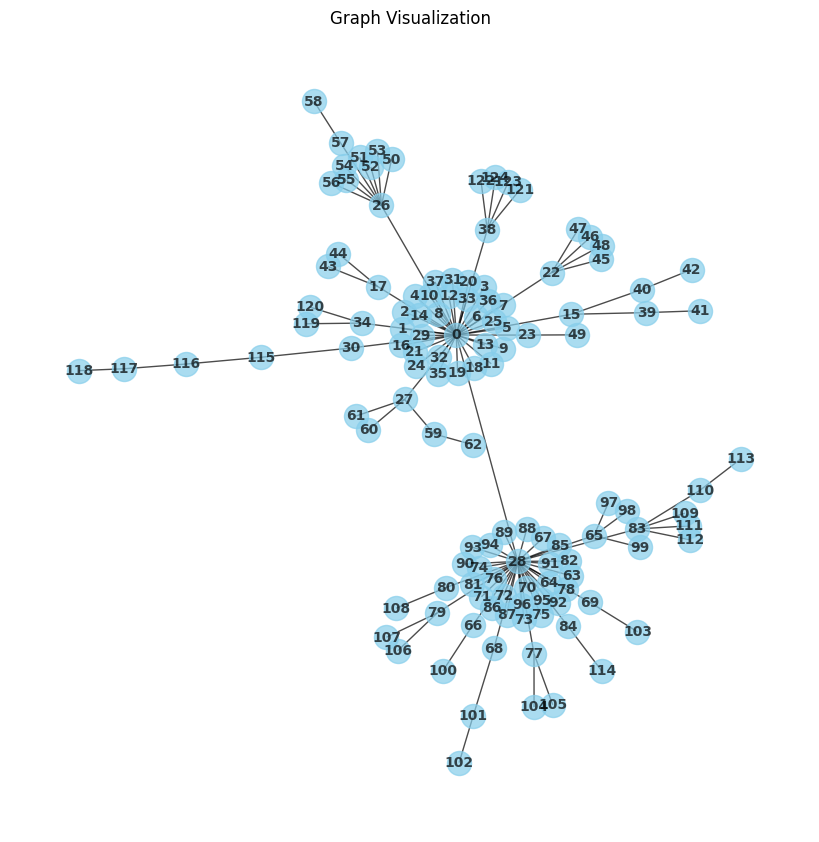

In [73]:
feature = 'content'

data = train_dataset[0]
test_tokens = data.x
print(f"number of data points: {test_tokens.shape}")

data = train_dataset[1]
print(data.y)
print(len(train_dataset))

# 1. Inspect the node features (x)
print(f"Node features shape: {data.x.shape}")
print(f"First 5 node features:\n{data.x[:5]}")

# 2. Inspect the edge index (edges between nodes)
print(f"Edge index shape: {data.edge_index.shape}")
print(f"First 5 edges:\n{data.edge_index[:, :5]}")

# 3. Visualize the graph using NetworkX
edge_index = data.edge_index
graph = nx.Graph()

# Add edges to the graph
for i in range(edge_index.shape[1]):
    source, target = edge_index[0, i].item(), edge_index[1, i].item()
    graph.add_edge(source, target)

# Visualize the graph (first 30 nodes for clarity)
plt.figure(figsize=(8, 8))
nx.draw(graph, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_weight='bold', alpha=0.7)
plt.title("Graph Visualization")
plt.show()



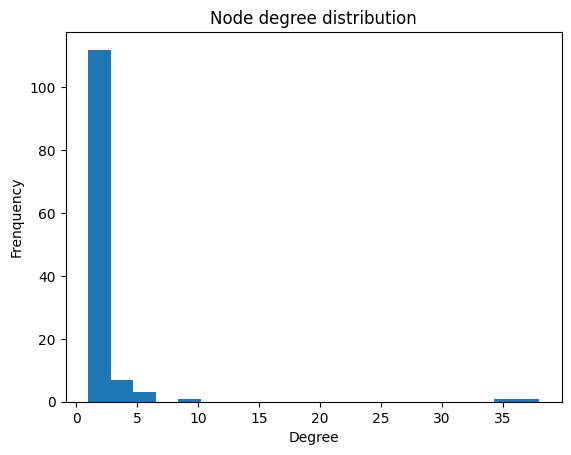

In [74]:
degrees = [degree for _, degree in graph.degree()]
plt.hist(degrees, bins=20)
plt.title("Node degree distribution")
plt.xlabel("Degree")
plt.ylabel("Frenquency")
plt.show()

# 2.0 Model Re-implementation

In [75]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

def train(model, optimizer, train_loader, device):
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    for data in loader:
        data = data.to(device)
        # Get the predicted probabilities (use `softmax` if necessary)
        out = model(data.x, data.edge_index, data.batch)
        all_labels.append(data.y.cpu().numpy())
        all_preds.append(out.cpu().numpy()[:, 1])  # Assuming binary classification (class 1 probabilities)

    # Flatten the list of arrays into a single array
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    # Calculate ROC AUC
    auc = roc_auc_score(all_labels, all_preds)

    return auc


# 2.1 Train the UPFD 2021 model on 2021 UPFD dataset
(user preference - aware fake news detection)
(already provided - built in example in torch-geometric)

In [37]:
class Net(torch.nn.Module):
    def __init__(self, model, in_channels, hidden_channels, out_channels,
                 concat=False):
        super().__init__()
        self.concat = concat

        if model == 'GCN':
            self.conv1 = GCNConv(in_channels, hidden_channels)
        elif model == 'SAGE':
            self.conv1 = SAGEConv(in_channels, hidden_channels)
        elif model == 'GAT':
            self.conv1 = GATConv(in_channels, hidden_channels)

        if self.concat:
            self.lin0 = Linear(in_channels, hidden_channels)
            self.lin1 = Linear(2 * hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index).relu()
        h = global_max_pool(h, batch)

        if self.concat:
            # Get the root node (tweet) features of each graph:
            root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
            root = torch.cat([root.new_zeros(1), root + 1], dim=0)
            news = x[root]

            news = self.lin0(news).relu()
            h = self.lin1(torch.cat([news, h], dim=-1)).relu()

        h = self.lin2(h)
        return h.log_softmax(dim=-1)

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(model_type, train_dataset.num_features, 128,
            train_dataset.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)


In [39]:
val_acc_2021 = []
train_acc_2021 = []

for epoch in range(1, 61):
    loss = train(model, optimizer, train_loader, device)
    train_acc = test(model, train_loader, device)
    val_acc = test(model, val_loader, device)
    val_acc_2021.append(val_acc)
    train_acc_2021.append(train_acc)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}')
test_acc = test(model, test_loader, device)
print(f'Test Accuracy: {test_acc:.4f}')


Epoch: 01, Loss: 0.7022, Train: 0.6227, Val: 0.6392
Epoch: 02, Loss: 0.5526, Train: 0.8095, Val: 0.8242
Epoch: 03, Loss: 0.4520, Train: 0.8342, Val: 0.8407
Epoch: 04, Loss: 0.4009, Train: 0.8581, Val: 0.8590
Epoch: 05, Loss: 0.3613, Train: 0.8709, Val: 0.8755
Epoch: 06, Loss: 0.3310, Train: 0.8819, Val: 0.8919
Epoch: 07, Loss: 0.3042, Train: 0.8965, Val: 0.8883
Epoch: 08, Loss: 0.2823, Train: 0.9139, Val: 0.9011
Epoch: 09, Loss: 0.2446, Train: 0.9203, Val: 0.9194
Epoch: 10, Loss: 0.2444, Train: 0.9304, Val: 0.9304
Epoch: 11, Loss: 0.2037, Train: 0.9505, Val: 0.9414
Epoch: 12, Loss: 0.1846, Train: 0.9533, Val: 0.9469
Epoch: 13, Loss: 0.1721, Train: 0.9570, Val: 0.9524
Epoch: 14, Loss: 0.1594, Train: 0.9570, Val: 0.9542
Epoch: 15, Loss: 0.1535, Train: 0.9597, Val: 0.9615
Epoch: 16, Loss: 0.1421, Train: 0.9579, Val: 0.9524
Epoch: 17, Loss: 0.1585, Train: 0.9643, Val: 0.9597
Epoch: 18, Loss: 0.1404, Train: 0.9625, Val: 0.9597
Epoch: 19, Loss: 0.1322, Train: 0.9606, Val: 0.9579
Epoch: 20, L

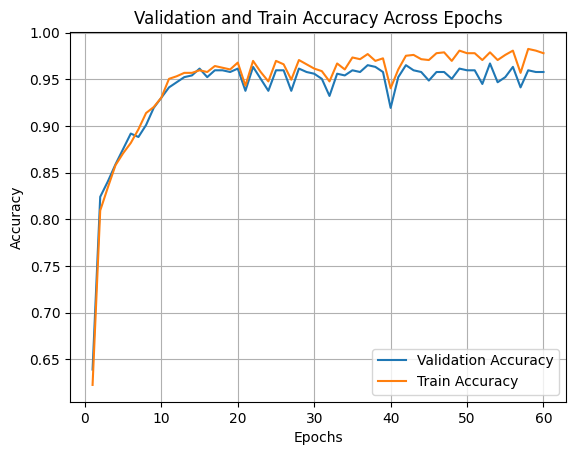

In [41]:
epochs = range(1, 61)

plt.plot(epochs, val_acc_2021, label='Validation Accuracy')
plt.plot(epochs, train_acc_2021, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Train Accuracy Across Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 2.2 Train FN-DGL 2019 model on 2021 UPFD dataset

In [76]:
from torch_geometric.nn import global_mean_pool, GATConv

class FN_Net(torch.nn.Module):
    def __init__(self, model, in_channels, hidden_channels, out_channels):

        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

        self.conv1 = GATConv(in_channels, hidden_channels * 2)
        self.conv2 = GATConv(hidden_channels * 2, hidden_channels * 2)

        self.fc1 = Linear(hidden_channels * 2, hidden_channels)
        self.fc2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):

        x = F.selu(self.conv1(x, edge_index))
        x = F.selu(self.conv2(x, edge_index))
        x = F.selu(global_mean_pool(x, batch))
        x = F.selu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)



In [56]:
dataset = 'gossipcop'  # Choose from ['politifact', 'gossipcop']
feature = 'spacy'  # Choose from ['profile', 'spacy', 'bert', 'content']
model_type = 'GAT'  # Choose from ['GCN', 'GAT', 'SAGE']

train_dataset = UPFD(path, dataset, feature, 'train', ToUndirected())
val_dataset = UPFD(path, dataset, feature, 'val', ToUndirected())
test_dataset = UPFD(path, dataset, feature, 'test', ToUndirected())

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FN_Net(model_type, train_dataset.num_features, 128,
            train_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)


In [57]:
val_acc_2021 = []
train_acc_2021 = []

for epoch in range(1, 61):
    loss = train(model, optimizer, train_loader, device)
    train_acc = test(model, train_loader, device)
    val_acc = test(model, val_loader, device)
    val_acc_2021.append(val_acc)
    train_acc_2021.append(train_acc)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}')
test_acc = test(model, test_loader, device)
print(f'Test Accuracy: {test_acc:.4f}')


Epoch: 01, Loss: 0.6968, Train: 0.5522, Val: 0.5678
Epoch: 02, Loss: 0.6613, Train: 0.6081, Val: 0.5861
Epoch: 03, Loss: 0.6184, Train: 0.7701, Val: 0.7894
Epoch: 04, Loss: 0.5313, Train: 0.7857, Val: 0.7985
Epoch: 05, Loss: 0.4529, Train: 0.7903, Val: 0.8114
Epoch: 06, Loss: 0.3792, Train: 0.8434, Val: 0.8425
Epoch: 07, Loss: 0.3600, Train: 0.8745, Val: 0.8883
Epoch: 08, Loss: 0.3188, Train: 0.9112, Val: 0.9194
Epoch: 09, Loss: 0.2671, Train: 0.9057, Val: 0.9158
Epoch: 10, Loss: 0.2430, Train: 0.9222, Val: 0.9304
Epoch: 11, Loss: 0.2246, Train: 0.9341, Val: 0.9322
Epoch: 12, Loss: 0.2207, Train: 0.9084, Val: 0.9048
Epoch: 13, Loss: 0.2394, Train: 0.9377, Val: 0.9524
Epoch: 14, Loss: 0.1852, Train: 0.9112, Val: 0.8736
Epoch: 15, Loss: 0.2104, Train: 0.8929, Val: 0.8828
Epoch: 16, Loss: 0.2083, Train: 0.9167, Val: 0.8993
Epoch: 17, Loss: 0.1879, Train: 0.9524, Val: 0.9524
Epoch: 18, Loss: 0.1598, Train: 0.9139, Val: 0.8974
Epoch: 19, Loss: 0.1977, Train: 0.8965, Val: 0.8645
Epoch: 20, L

# 2.3 Train FN-GDL Train all combinations

In [77]:
def run_model(model, optimizer, train_loader, val_loader, test_loader, device): 
    val_acc_2019 = []
    train_acc_2019 = []

    epochs = range(1, 51)

    for epoch in epochs:
        loss = train(model, optimizer, train_loader, device)
        train_acc = test(model, train_loader, device)
        val_acc= test(model, val_loader, device)
        val_acc_2019.append(val_acc)
        train_acc_2019.append(train_acc)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
            f'Val: {val_acc:.4f}')
    test_acc= test(model, test_loader, device)
    print(f'Test: {test_acc:.4f}')
    return test_acc

In [79]:
datasets = ['politifact', 'gossipcop']
features =  ['profile', 'spacy', 'bert', 'content']
model_type = 'GAT'
path = os.path.join(os.getcwd(), 'data', 'UPFD')
test_accs = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np
for dataset in datasets:
    for feature in features:
        train_dataset = UPFD(path, dataset, feature, 'train', ToUndirected())
        val_dataset = UPFD(path, dataset, feature, 'val', ToUndirected())
        test_dataset = UPFD(path, dataset, feature, 'test', ToUndirected())

        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        model = FN_Net(model_type, train_dataset.num_features, 128,
            train_dataset.num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

        test_acc = run_model(model, optimizer, train_loader, val_loader, test_loader, device)
        test_accs.append({'dataset': dataset, 'feature': feature, 'test_acc': test_acc})


Epoch: 01, Loss: 0.6886, Train: 0.8162, Val: 0.6709
Epoch: 02, Loss: 0.6477, Train: 0.8312, Val: 0.6880
Epoch: 03, Loss: 0.6331, Train: 0.8515, Val: 0.7051
Epoch: 04, Loss: 0.6242, Train: 0.8611, Val: 0.7222
Epoch: 05, Loss: 0.6297, Train: 0.8611, Val: 0.7350
Epoch: 06, Loss: 0.5821, Train: 0.8643, Val: 0.7350
Epoch: 07, Loss: 0.5586, Train: 0.8707, Val: 0.7350
Epoch: 08, Loss: 0.5656, Train: 0.8750, Val: 0.7393
Epoch: 09, Loss: 0.5597, Train: 0.8793, Val: 0.7436
Epoch: 10, Loss: 0.5124, Train: 0.8835, Val: 0.7436
Epoch: 11, Loss: 0.5120, Train: 0.8857, Val: 0.7479
Epoch: 12, Loss: 0.4857, Train: 0.8932, Val: 0.7521
Epoch: 13, Loss: 0.4599, Train: 0.9006, Val: 0.7607
Epoch: 14, Loss: 0.4630, Train: 0.9028, Val: 0.7607
Epoch: 15, Loss: 0.4136, Train: 0.9049, Val: 0.7607
Epoch: 16, Loss: 0.4253, Train: 0.9103, Val: 0.7607
Epoch: 17, Loss: 0.4056, Train: 0.9156, Val: 0.7650
Epoch: 18, Loss: 0.3960, Train: 0.9167, Val: 0.7650
Epoch: 19, Loss: 0.3796, Train: 0.9220, Val: 0.7650
Epoch: 20, L

In [82]:
test_accs

[{'dataset': 'politifact',
  'feature': 'profile',
  'test_acc': 0.8225172074729598},
 {'dataset': 'politifact', 'feature': 'spacy', 'test_acc': 0.9029006882989185},
 {'dataset': 'politifact', 'feature': 'bert', 'test_acc': 0.886758439855785},
 {'dataset': 'politifact', 'feature': 'content', 'test_acc': 0.92608980662078},
 {'dataset': 'gossipcop',
  'feature': 'profile',
  'test_acc': 0.9487518991354151},
 {'dataset': 'gossipcop', 'feature': 'spacy', 'test_acc': 0.9824345003224432},
 {'dataset': 'gossipcop', 'feature': 'bert', 'test_acc': 0.9810313261703593},
 {'dataset': 'gossipcop',
  'feature': 'content',
  'test_acc': 0.9895544819595797}]

/var/folders/x4/r_rk2kln4kv4g6nw09s3pp7h0000gn/T/ipykernel_21473/2644929047.py:13: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  bar_plot = sns.barplot(data=df, x='feature', y='test_acc', hue='dataset', palette=palette)


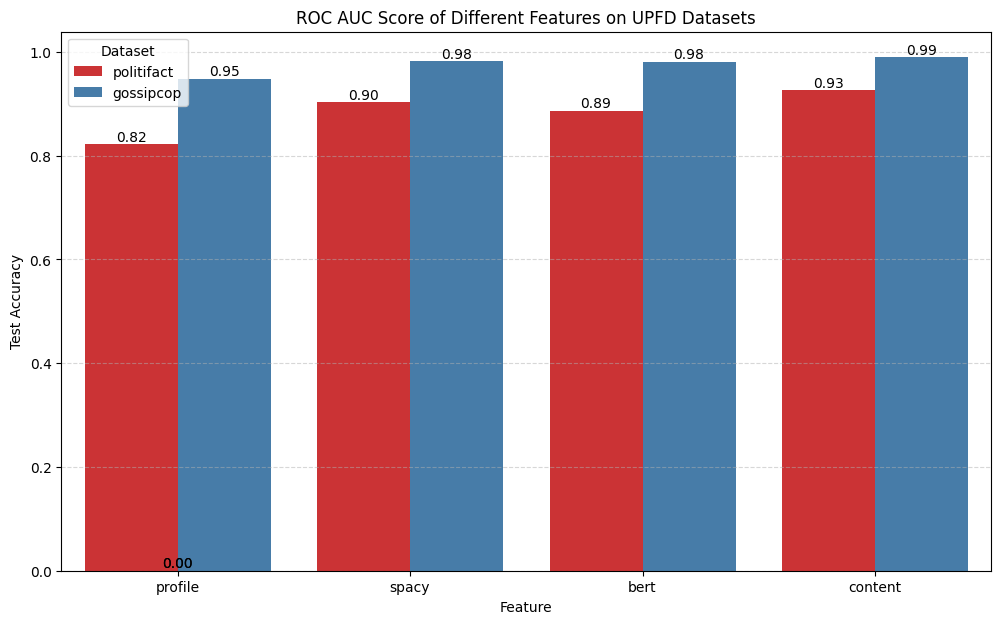

In [80]:
df = pd.DataFrame(test_accs)

# Set the size of the plot
plt.figure(figsize=(12, 7))

# Create a bar plot with Seaborn using a custom color palette
palette = sns.color_palette("Set1")  # Nice color palette
bar_plot = sns.barplot(data=df, x='feature', y='test_acc', hue='dataset', palette=palette)

# Add the value of the bar above each bar
for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.annotate(f'{height:.2f}', xy=(p.get_x() + p.get_width() / 2., height), 
                      ha='center', va='bottom', fontsize=10)

# Customize the plot
plt.title('ROC AUC Score of Different Features on UPFD Datasets')
plt.xlabel('Feature')
plt.ylabel('Test Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Dataset')
plt.show()


## 3.0 Exploring with Centrality Measures

In [93]:
from torch_geometric.utils import to_networkx

# Function to compute centrality measures
def compute_centrality(graph):
    nx_graph = to_networkx(graph, to_undirected=True)
    centrality_measures = {
        'degree': nx.degree_centrality(nx_graph),
        'betweenness': nx.betweenness_centrality(nx_graph),
        'pagerank': nx.pagerank(nx_graph),
    }
    return centrality_measures

# Analyze centrality for all graphs in a dataset
def analyze_centrality(dataset, label_map):
    results = {'fake': [], 'real': []}

    for data in dataset:
        centrality_measures = compute_centrality(data)
        label = label_map[int(data.y)]  # Map label (0 or 1) to 'fake' or 'real'
        
        for measure, values in centrality_measures.items():
            avg_value = sum(values.values()) / len(values)  # Compute average centrality
            results[label].append((measure, avg_value))
    return results


# 3.1 Centrality with Boxplots - Gossipcop

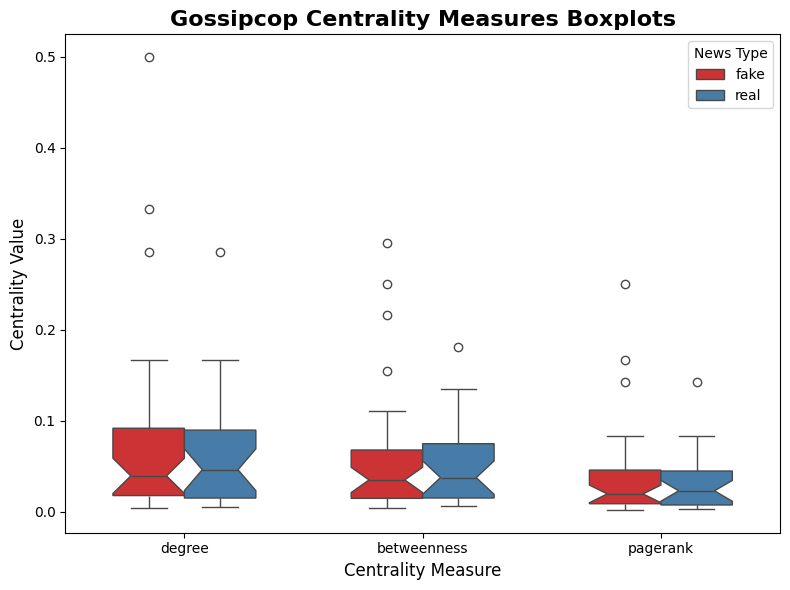

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

label_map = {0: 'fake', 1: 'real'}

def plot_centrality_boxplots(results, title="Gossipcop"):
    # Organize results into a DataFrame
    centrality_data = []
    for label, centralities in results.items():
        # Ensure label is mapped correctly
        mapped_label = label_map.get(label, label)  # Use the label directly if it's already 'fake' or 'real'
        for measure, value in centralities:
            centrality_data.append({'Type': measure, 'Label': mapped_label, 'Value': value})
    
    centrality_df = pd.DataFrame(centrality_data)

    # Create a single plot with boxplots for all measures
    plt.figure(figsize=(8, 6))
    sns.boxplot(
        x='Type', 
        y='Value', 
        hue='Label', 
        data=centrality_df, 
        palette='Set1', 
        width=0.6, 
        notch=True
    )

    # Add title and labels
    plt.title(f'{title} Centrality Measures Boxplots', fontsize=16, fontweight='bold')
    plt.xlabel('Centrality Measure', fontsize=12)
    plt.ylabel('Centrality Value', fontsize=12)
    #plt.xticks(rotation=45)
    plt.legend(title='News Type', loc='upper right')

    # Display the plot
    plt.tight_layout()
    plt.show()


# Analyze centrality
results = analyze_centrality(train_dataset, label_map)

# Plot box plots for each centrality type
plot_centrality_boxplots(results)


## 3.1 Centrality with Boxplots - Politifact

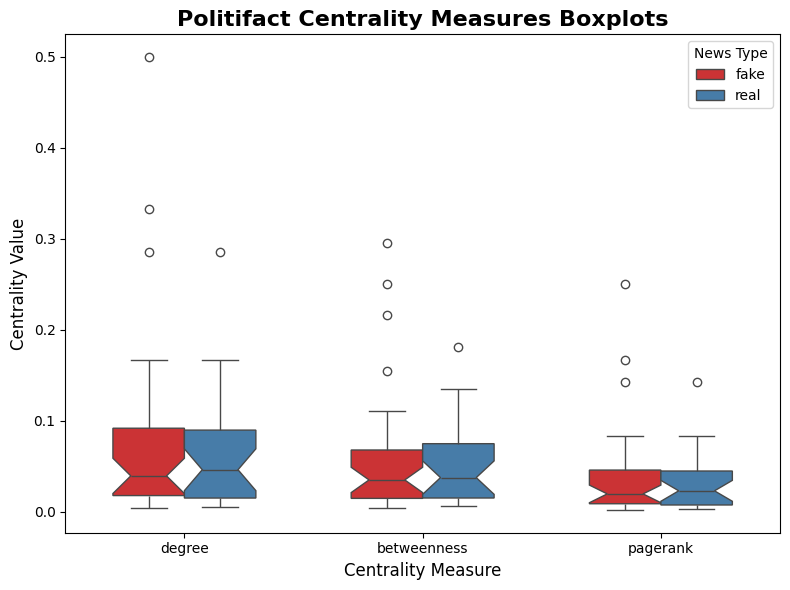

In [97]:
dataset = "politifact"
feature = "content"
train_dataset = UPFD(path, dataset, feature, 'train', ToUndirected())
test_dataset = UPFD(path, dataset, feature, 'test', ToUndirected())

results = analyze_centrality(train_dataset, label_map)

plot_centrality_boxplots(results, title="Politifact")

# 4.0 Comparisons of Baseline ROC AUC

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

path = os.path.join(os.getcwd(), 'data', 'UPFD')

centrality_map = {
    'degree': nx.degree_centrality,
    'betweenness': nx.betweenness_centrality,
    'pagerank': nx.pagerank,
}

def train_and_evaluate_models(train_dataset, test_dataset, label_map, model, input):
    def extract_features_and_labels(dataset):
        features, labels = [], []
        for data in dataset:
            G = to_networkx(data, to_undirected=True)
            centrality = centrality_map[centrality_type](G)
            avg_centrality = np.mean(list(centrality.values()))
            content_feature = data.x[0].numpy()
            
            if input == 'content':
                combined_feature = content_feature
            elif input == 'centrality':
                combined_feature = [avg_centrality]
            elif input == 'combined':
                combined_feature = np.concatenate([content_feature, [avg_centrality]])
            
            features.append(combined_feature)
            labels.append(data.y.item())
        return np.array(features), np.array(labels)

    train_features, train_labels = extract_features_and_labels(train_dataset)
    test_features, test_labels = extract_features_and_labels(test_dataset)

    model.fit(train_features, train_labels)
    
    test_probabilities = model.predict(test_features)
    
    roc_auc = roc_auc_score(test_labels, test_probabilities)
    return roc_auc

label_map = {'fake': 0, 'real': 1}

all_results_ROC = []

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


datasets = ['gossipcop', 'politifact']
features = ['spacy', 'bert', 'content']
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    #"Naive Bayes": GaussianNB(),
    #"Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    }

centrality_types = ['degree', 'betweenness', 'pagerank']
inputs = ['content', 'centrality', 'combined']

for dataset in datasets:
    for feature in features:
        for centrality_type in centrality_types:
            for model_name, model_class in models.items():
                for input in inputs:
                    train_dataset = UPFD(path, dataset, feature, 'train', ToUndirected())
                    test_dataset = UPFD(path, dataset, feature, 'test', ToUndirected())
                    results = train_and_evaluate_models(train_dataset, test_dataset, label_map, model_class, input)
                    all_results_ROC.append({
                        "dataset": dataset,
                        "feature": feature,
                        "centrality": centrality_type,
                        "model": model_name,
                        "input": input,
                        "roc_auc": round(results, 3)  # Round the ROC AUC score to 3 decimal points
                    })
                    print({
                        "dataset": dataset,
                        "feature": feature,
                        "centrality": centrality_type,
                        "model": model_name,
                        "input": input,
                        "roc_auc": round(results, 3)
                    })

all_results_df_ROC = pd.DataFrame(all_results_ROC)
all_results_df_ROC


{'dataset': 'politifact', 'feature': 'spacy', 'centrality': 'degree', 'model': 'Logistic Regression', 'input': 'content', 'roc_auc': 0.726}
{'dataset': 'politifact', 'feature': 'spacy', 'centrality': 'degree', 'model': 'Logistic Regression', 'input': 'centrality', 'roc_auc': 0.5}
{'dataset': 'politifact', 'feature': 'spacy', 'centrality': 'degree', 'model': 'Logistic Regression', 'input': 'combined', 'roc_auc': 0.726}
{'dataset': 'politifact', 'feature': 'spacy', 'centrality': 'betweenness', 'model': 'Logistic Regression', 'input': 'content', 'roc_auc': 0.726}
{'dataset': 'politifact', 'feature': 'spacy', 'centrality': 'betweenness', 'model': 'Logistic Regression', 'input': 'centrality', 'roc_auc': 0.5}
{'dataset': 'politifact', 'feature': 'spacy', 'centrality': 'betweenness', 'model': 'Logistic Regression', 'input': 'combined', 'roc_auc': 0.726}
{'dataset': 'politifact', 'feature': 'spacy', 'centrality': 'pagerank', 'model': 'Logistic Regression', 'input': 'content', 'roc_auc': 0.726}

,dataset,feature,centrality,model,input,roc_auc
0,politifact,spacy,degree,Logistic Regression,content,0.726
1,politifact,spacy,degree,Logistic Regression,centrality,0.500
2,politifact,spacy,degree,Logistic Regression,combined,0.726
3,politifact,spacy,betweenness,Logistic Regression,content,0.726
4,politifact,spacy,betweenness,Logistic Regression,centrality,0.500
5,politifact,spacy,betweenness,Logistic Regression,combined,0.726
6,politifact,spacy,pagerank,Logistic Regression,content,0.726
7,politifact,spacy,pagerank,Logistic Regression,centrality,0.500
8,politifact,spacy,pagerank,Logistic Regression,combined,0.726
9,politifact,bert,degree,Logistic Regression,content,0.802


# 4.1 Gossipcop ROC AUC

In [59]:
filtered_df_ROC = pd.DataFrame(
    all_results_df_ROC[
        (all_results_df_ROC['dataset'] == 'gossipcop')
    ]
).sort_values(by='roc_auc', ascending=False)

filtered_df_ROC[['feature', 'centrality', 'model', 'input', 'roc_auc']][:]

,feature,centrality,model,input,roc_auc
53,content,pagerank,Logistic Regression,combined,0.983
51,content,pagerank,Logistic Regression,content,0.983
50,content,betweenness,Logistic Regression,combined,0.983
48,content,betweenness,Logistic Regression,content,0.983
45,content,degree,Logistic Regression,content,0.983
47,content,degree,Logistic Regression,combined,0.982
29,spacy,degree,Logistic Regression,combined,0.873
32,spacy,betweenness,Logistic Regression,combined,0.872
35,spacy,pagerank,Logistic Regression,combined,0.852
38,bert,degree,Logistic Regression,combined,0.833


# 4.2 Politifact ROC AUC

In [88]:
filtered_df_ROC = pd.DataFrame(
    all_results_df_ROC[
        (all_results_df_ROC['dataset'] == 'gossipcop')
    ]
).sort_values(by='roc_auc', ascending=False)

filtered_df_ROC[['feature', 'centrality', 'model', 'input', 'roc_auc']][:]

,feature,centrality,model,input,roc_auc
38,content,degree,Logistic Regression,combined,0.952
44,content,betweenness,Logistic Regression,combined,0.951
36,content,degree,Logistic Regression,content,0.951
50,content,pagerank,Logistic Regression,combined,0.951
48,content,pagerank,Logistic Regression,content,0.951
42,content,betweenness,Logistic Regression,content,0.951
45,content,betweenness,Decision Tree,content,0.908
39,content,degree,Decision Tree,content,0.908
51,content,pagerank,Decision Tree,content,0.908
41,content,degree,Decision Tree,combined,0.906


# 5.0 Filter Tables

In [90]:
# Filter and sort the DataFrame
filtered_df_ROC = pd.DataFrame(
    all_results_df_ROC[
        (all_results_df_ROC['dataset'] == 'gossipcop')
    ]
).sort_values(by='roc_auc', ascending=False)

# Apply the conditions to update columns
filtered_df_ROC.loc[filtered_df_ROC['input'] == 'content', 'centrality'] = ''
filtered_df_ROC.loc[filtered_df_ROC['input'] == 'centrality', 'feature'] = ''

# Drop duplicates
filtered_df_ROC = filtered_df_ROC.drop_duplicates()

# Select the relevant columns
filtered_df_ROC = filtered_df_ROC[['feature', 'centrality', 'model', 'input', 'roc_auc']]
filtered_df_ROC

,feature,centrality,model,input,roc_auc
38,content,degree,Logistic Regression,combined,0.952
44,content,betweenness,Logistic Regression,combined,0.951
36,content,,Logistic Regression,content,0.951
50,content,pagerank,Logistic Regression,combined,0.951
45,content,,Decision Tree,content,0.908
41,content,degree,Decision Tree,combined,0.906
53,content,pagerank,Decision Tree,combined,0.906
47,content,betweenness,Decision Tree,combined,0.902
2,spacy,degree,Logistic Regression,combined,0.798
8,spacy,betweenness,Logistic Regression,combined,0.796


In [91]:
# Filter and sort the DataFrame
filtered_df_ROC = pd.DataFrame(
    all_results_df_ROC[
        (all_results_df_ROC['dataset'] == 'politifact')
    ]
).sort_values(by='roc_auc', ascending=False)

# Apply the conditions to update columns
filtered_df_ROC.loc[filtered_df_ROC['input'] == 'content', 'centrality'] = ''
filtered_df_ROC.loc[filtered_df_ROC['input'] == 'centrality', 'feature'] = ''

# Drop duplicates
filtered_df_ROC = filtered_df_ROC.drop_duplicates()

# Select the relevant columns
filtered_df_ROC = filtered_df_ROC[['feature', 'centrality', 'model', 'input', 'roc_auc']]
filtered_df_ROC

,feature,centrality,model,input,roc_auc
90,content,,Logistic Regression,content,0.853
104,content,pagerank,Logistic Regression,combined,0.853
98,content,betweenness,Logistic Regression,combined,0.853
92,content,degree,Logistic Regression,combined,0.853
74,bert,degree,Logistic Regression,combined,0.802
78,bert,,Logistic Regression,content,0.802
80,bert,betweenness,Logistic Regression,combined,0.802
86,bert,pagerank,Logistic Regression,combined,0.802
107,content,pagerank,Decision Tree,combined,0.738
101,content,betweenness,Decision Tree,combined,0.738
